In [1]:
# env init
import os
import pickle

import cv2
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

os.environ["LOKY_MAX_CPU_COUNT"] = "8"
os.environ["OMP_NUM_THREADS"] = "4"

In [2]:
# augment part
env = "augment"

# path init
# check env dir if exist in working path
if not os.path.exists("./" + env):
    os.makedirs("./" + env)
working_path = "./" + env
# check img dir if exist in working path
if not os.path.exists(working_path + "/img"):
    os.makedirs(working_path + "/img")
# read df csv
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

categories = [
    d
    for d in os.listdir("./Aerial_Landscapes")
    if os.path.isdir(os.path.join("./Aerial_Landscapes", d))
]  # because original dataset already split imgs into folders with specific names, so use it as label

In [3]:
# prepare the dataframe

# get a copy of the original dataframe, prevent overwriting the original dataframe
train_df_augment = train_df.copy()
# because augment need to edit img, so save edited img to a new folder, not in the original folder
image_augment_paths = []
image_augment_labels = []

def augment_image(image):
    # rotate
    angle = np.random.randint(0, 360)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h))

    # flip
    flip = np.random.choice([0, 1])
    image = cv2.flip(image, flip)

    # noise
    noise = np.random.normal(0, 0.1, image.shape).astype(np.float32)
    image = image.astype(np.float32) + noise
    image = np.clip(image, 0, 255).astype(np.uint8)

    # brightness
    brightness = np.random.randint(-50, 50)
    image = image.astype(np.int16) + brightness
    image = np.clip(image, 0, 255).astype(np.uint8)

    return image

# augment the images in the dataframe
for i in range(len(train_df_augment)):
    image_path = train_df_augment.iloc[i]["image_path"]
    image_label = train_df_augment.iloc[i]["label"]
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error reading image {image_path}")
        continue
    # augment the image
    augmented_image = augment_image(image)
    # save the augmented image to the dataframe
    augmented_image_path = os.path.join(working_path + "/img", f"{image_label}_{i}.jpg")
    # replace \ with / in the path
    augmented_image_path = augmented_image_path.replace("\\", "/")

    cv2.imwrite(
        augmented_image_path, augmented_image
    )  # save the augmented image to the new folder

    print(f"Augmented image saved to {augmented_image_path}， label: {image_label}，name: {image_path}")
    image_augment_paths.append(augmented_image_path)
    image_augment_labels.append(image_label)

# add the augmented images to the dataframe
train_df_augment = pd.DataFrame({"image_path": image_augment_paths, "label": image_augment_labels})

# show count of images
print(train_df_augment["label"].value_counts())

# save the dataframe to a csv file
train_df_augment.to_csv(working_path + "/train_augment.csv", index=False)

# ETA 56s
# see count of images
print(train_df_augment["label"].value_counts())

Augmented image saved to ./augment/img/Airport_0.jpg， label: Airport，name: E:/repo/9517/SIFT-KNN/Aerial_Landscapes/Airport/395.jpg
Augmented image saved to ./augment/img/Residential_1.jpg， label: Residential，name: E:/repo/9517/SIFT-KNN/Aerial_Landscapes/Residential/305.jpg
Augmented image saved to ./augment/img/Residential_2.jpg， label: Residential，name: E:/repo/9517/SIFT-KNN/Aerial_Landscapes/Residential/409.jpg
Augmented image saved to ./augment/img/Mountain_3.jpg， label: Mountain，name: E:/repo/9517/SIFT-KNN/Aerial_Landscapes/Mountain/577.jpg
Augmented image saved to ./augment/img/Grassland_4.jpg， label: Grassland，name: E:/repo/9517/SIFT-KNN/Aerial_Landscapes/Grassland/547.jpg
Augmented image saved to ./augment/img/Port_5.jpg， label: Port，name: E:/repo/9517/SIFT-KNN/Aerial_Landscapes/Port/202.jpg
Augmented image saved to ./augment/img/Highway_6.jpg， label: Highway，name: E:/repo/9517/SIFT-KNN/Aerial_Landscapes/Highway/379.jpg
Augmented image saved to ./augment/img/Airport_7.jpg， label

In [4]:
# SIFT for getting keypoints and descriptors
sift_augment = cv2.SIFT_create()
# save sift descriptors and keypoints
sift_augment_descriptors_list = []

# start sift, only on train df augment
for index, row in train_df_augment.iterrows():
    image_path = row["image_path"]
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, descriptors = sift_augment.detectAndCompute(gray_image, None)

    if descriptors is not None and descriptors.ndim == 2:
        sift_augment_descriptors_list.append(descriptors)

# show number of keypoints and descriptors
print("###AUGMENT TRAIN DF###")
print(f"Number of descriptors: {len(sift_augment_descriptors_list)}")

# save
with open(working_path + "/sift_augment_descriptors_list.pkl", "wb") as f:
    pickle.dump(sift_augment_descriptors_list, f)
# ETA 2m 38s

###AUGMENT TRAIN DF###
Number of descriptors: 9568


In [5]:
# build boW

# flatten the list of descriptors and fit kmeans
if sift_augment_descriptors_list:
    all_descriptors = np.vstack(sift_augment_descriptors_list)

# define KNN config
k = 300  # number of clusters
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42,batch_size=2048)
kmeans.fit(all_descriptors)

def get_bow_histogram(descriptors, kmeans):
    if descriptors is not None:
        # predict the cluster for each descriptor
        cluster_indices = kmeans.predict(descriptors)
        # count the occurrences of each cluster index
        histogram, _ = np.histogram(cluster_indices, bins=np.arange(k + 1), density=True)
        return histogram
    else:
        # if descriptors is None, return a zero histogram
        return np.zeros(k)

def get_bow_features(dataframe, image_path, kmeans):
    x_temp = []
    y_temp = []

    for index, row in dataframe.iterrows():
        image_path = row['image_path']
        image = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        __, descriptors = sift_augment.detectAndCompute(gray_image, None)

        # get the histogram for the image
        histogram = get_bow_histogram(descriptors, kmeans)

        x_temp.append(histogram)
        y_temp.append(row['label'])
    return np.array(x_temp), np.array(y_temp)

x_train = []
y_train = []

for index, row in train_df_augment.iterrows():
    image_path = row['image_path']
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift_augment.detectAndCompute(gray_image, None)

    # get the histogram for the image
    histogram = get_bow_histogram(descriptors, kmeans)

    x_train.append(histogram)
    y_train.append(row['label'])

# convert to numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test, y_test = get_bow_features(test_df, image_path, kmeans)

# save to disk
np.save(working_path + '/x_train.npy', x_train)
np.save(working_path + '/y_train.npy', y_train)
np.save(working_path + '/x_test.npy', x_test)
np.save(working_path + '/y_test.npy', y_test)
# ETA 4m 38s

d:\Dev\anaconda3\envs\SIFT_KNN\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


In [6]:
# start training, by KNN


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

# test the model on test set
y_pred = knn.predict(x_test)


# save knn model
joblib.dump(knn, working_path + '/knn_model.pkl')
np.save(working_path + '/y_pred.npy', y_pred)
np.save(working_path + '/y_test.npy', y_test)

In [7]:
# read y_pred and y_val_pred from disk
working_path = "./augment/"
y_pred = np.load(working_path + 'y_pred.npy')
# read y_test and y_val from disk
y_test = np.load(working_path + 'y_test.npy')
categories = [
    d
    for d in os.listdir("./Aerial_Landscapes")
    if os.path.isdir(os.path.join("./Aerial_Landscapes", d))
]  # because original dataset already split imgs into folders with specific names, so use it as label

Accuracy: 0.50
              precision    recall  f1-score   support

 Agriculture       0.63      0.36      0.45       160
     Airport       0.37      0.40      0.38       160
       Beach       0.44      0.21      0.28       160
        City       0.38      0.75      0.50       160
      Desert       0.62      0.37      0.46       160
      Forest       0.56      0.91      0.69       160
   Grassland       0.70      0.23      0.35       160
     Highway       0.39      0.43      0.41       160
        Lake       0.34      0.11      0.17       160
    Mountain       0.46      0.80      0.59       160
     Parking       0.77      0.82      0.79       160
        Port       0.84      0.38      0.52       160
     Railway       0.43      0.84      0.57       160
 Residential       0.57      0.76      0.65       160
       River       0.32      0.11      0.17       160

    accuracy                           0.50      2400
   macro avg       0.52      0.50      0.47      2400
weighted av

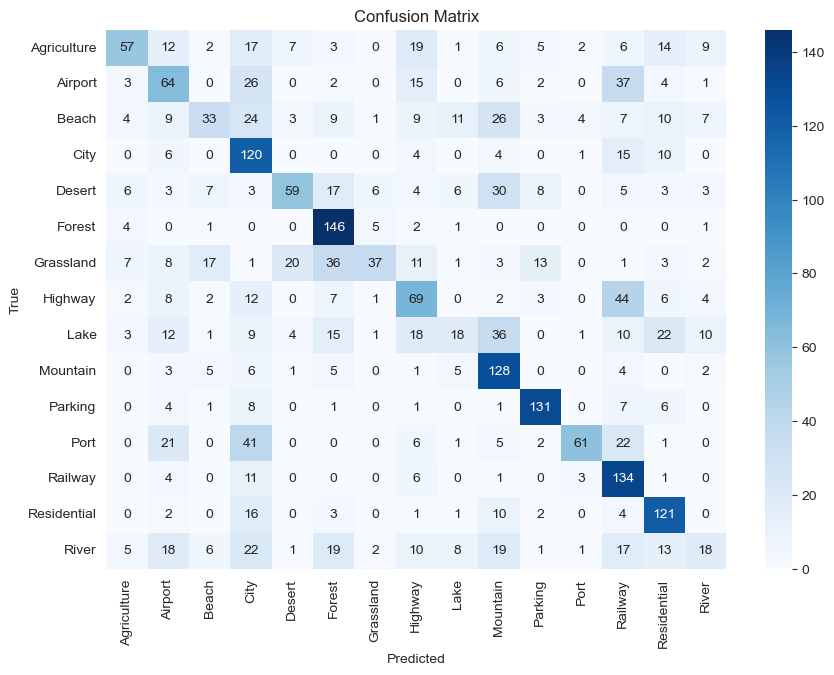

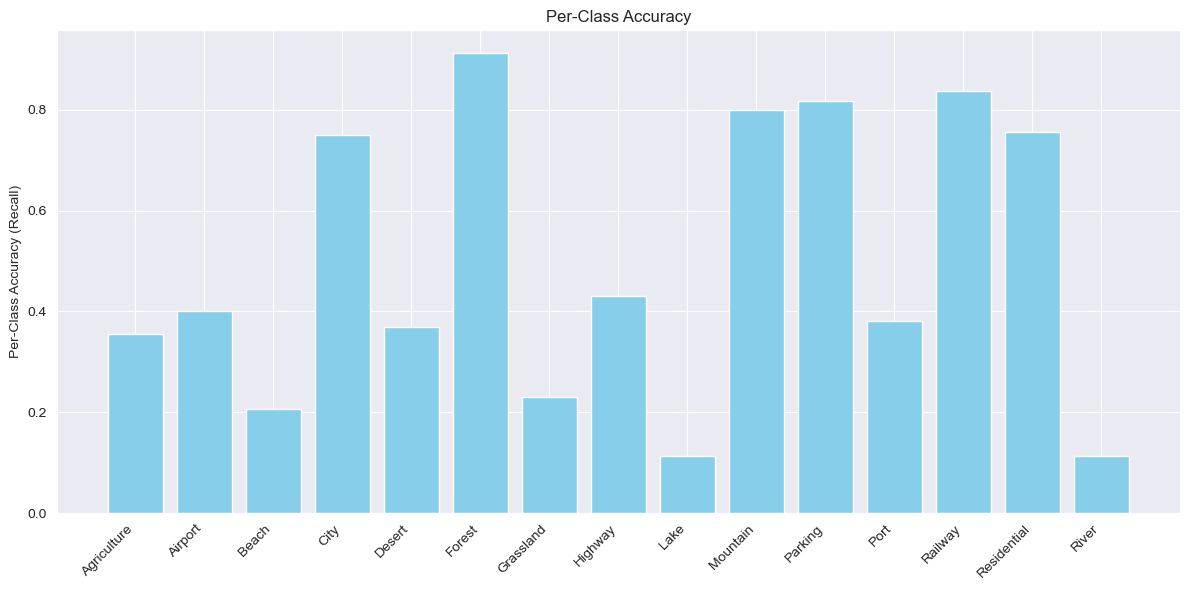

In [8]:
# show results by plt


# show accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred, target_names=categories))

# show confusion matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred, labels=categories)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# show accuracy by each cateq,using bar chart via plt
# x axis, y axis accuracy
per_class_acc = np.diag(cm) / cm.sum(axis=1)
plt.figure(figsize=(12, 6))
plt.bar(categories, per_class_acc, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Per-Class Accuracy (Recall)')
plt.title('Per-Class Accuracy')
plt.tight_layout()
plt.show()
